# Federated Learning of U-Net for Pneumothorax Segmentation - Part 1

## Introduction

This notebook demonstrates an example of federated learning without parameter aggregation, i.e., by sending the model to a worker, training locally on a batch of data, retrieving it back and then repeating the process with the other batches located on the same or other workers.

We're using an example dataset from the [Pneumothorax Segmentation Kaggle competition](https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation). 

## Imports

In [0]:
import time
import copy
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
 
from torch.utils.data import random_split, DataLoader
from torchvision.transforms import Compose, Resize, ToTensor


# A few constants we'll be using
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IMG_SIZE = 256 # Input image size 
BATCH_SIZE = 2 # Batch size 
ROOT_DIR = './sample images/' # Input files folder
RLE_FILENAME = "train-rle-sample.csv" # Name of the file with masks
VAL_SPLIT = 0.4 # Part of the dataset used for validation

## Data Preprocessing

The data for the Pneumothorax competition is provided in the form of [Dicom](https://en.wikipedia.org/wiki/DICOMµ) files that contain images together with patient data and a CSV file with [RLE-encoded](https://en.wikipedia.org/wiki/Run-length_encoding) binary masks for each file. In `dataset.py` We've provided a custom PyTorch Dataset class that imports the Dicom files from the folder, decodes the RLE masks and returns the images and corresponding masks in the `PIL.Image` format. The transforms specified below resize the images and convert them to PyTorch tensors:

In [0]:
from dataset import SegmentationDataset

transforms = Compose([
        Resize(IMG_SIZE),
        ToTensor(),
    ])

dataset = SegmentationDataset(ROOT_DIR, RLE_FILENAME,
                              input_transform=transforms,
                              target_transform=transforms
                             )

Next, we split it into two datasets for training and validation and create dataloaders. In real life, this data would be located at different hospitals, so we're going to distribute these datasets among the virtual workers later and pretend we never had access to them.

In [0]:
dataset_len = len(dataset)
val_len = int(np.floor(VAL_SPLIT * dataset_len))
train_len = dataset_len - val_len

dataset_train, dataset_val = random_split(dataset, [train_len, val_len])

dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=True)

## Explore the data

Here's what the imported data looks like: 

Batch 1
Input shape: torch.Size([2, 3, 256, 256])
Target shape: torch.Size([2, 1, 256, 256])
Image 1


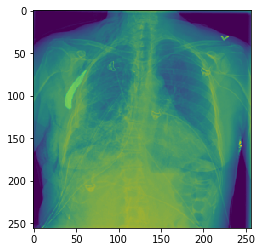

Image 2


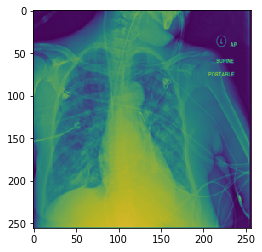

Batch 2
Input shape: torch.Size([2, 3, 256, 256])
Target shape: torch.Size([2, 1, 256, 256])
Image 1


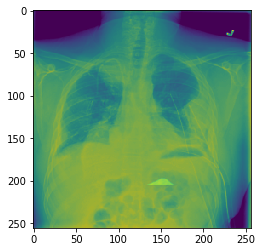

Image 2


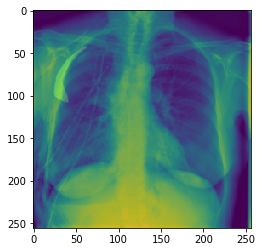

Batch 3
Input shape: torch.Size([2, 3, 256, 256])
Target shape: torch.Size([2, 1, 256, 256])
Image 1


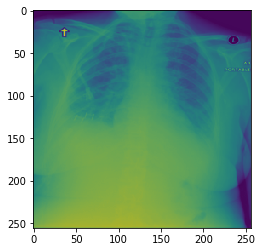

Image 2


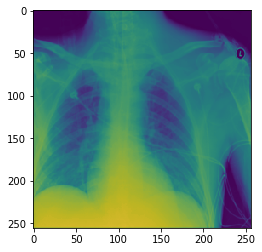

In [4]:
for i, (x, y) in enumerate(dataloader_train):
    print(f"Batch {i+1}")
    print(f"Input shape: {x.shape}")
    print(f"Target shape: {y.shape}")
    
    for image in range(dataloader_train.batch_size):
        print(f"Image {image+1}")
        plt.figure()
        plt.imshow(Image.fromarray(x[image][0,:,:].numpy()))
        plt.imshow(Image.fromarray(y[image][0,:,:].numpy()), alpha=0.2)
        plt.show()

## Model 

### U-Net Architecture

U-Net is a convolutional neural network developed for biomedical image segmentation by Olaf Ronneberger, Philipp Fischer, Thomas Brox in 2015 at the paper ["UNet: Convolutional Networks for Biomedical Image Segmentation"](https://arxiv.org/abs/1505.04597). It is based on Fully Convolutional Network architecture proposed by Evan Shelhamer, Jonathan Long, Trevor Darrellin their paper ["Fully convolutional networks for semantic segmentation"](https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf). Here's what the U-Net architecture looks like: 

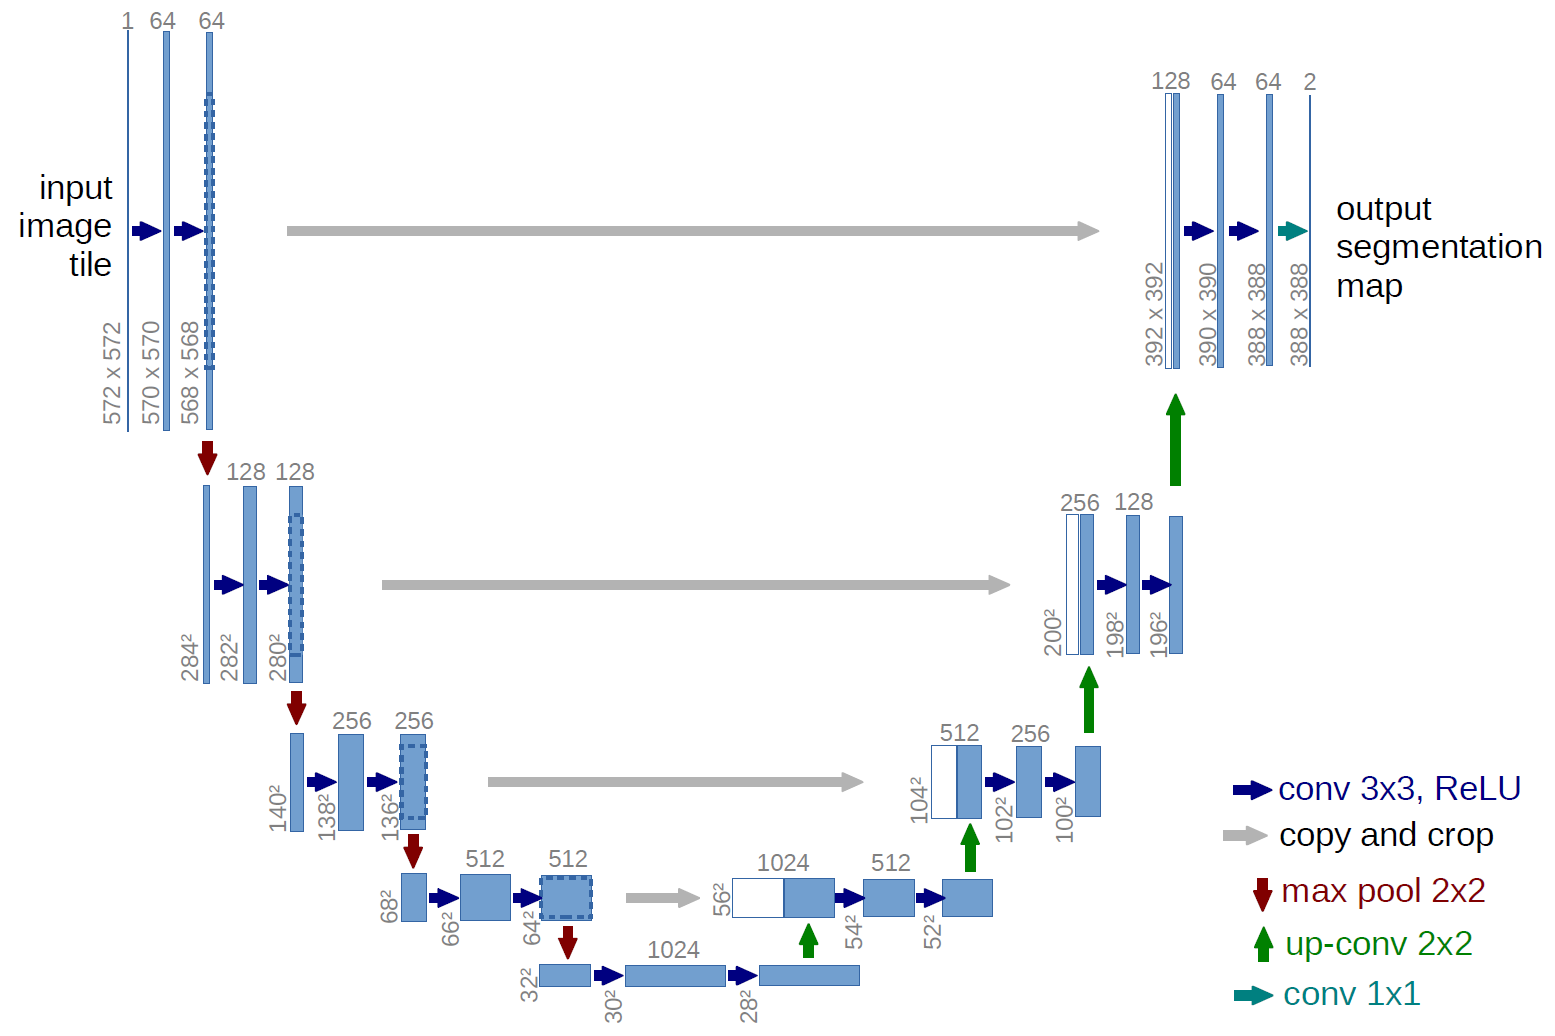

In [5]:
## image source: https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/
from IPython.display import Image
Image("assets/u-net-architecture.png", width=700)

### Implementation
The implementation was taken from https://github.com/usuyama/pytorch-unet and can be found in the file `model.py` (and modified if needed):

In [0]:
from model import UNet

# We're predicting a one-channel mask for absence or presence of Pneumothorax 
channels_out = 1 
unet = UNet(channels_out).to(device)

### Functions used for loss calculation

Here we're using a weighted average of binary crossentropy loss and [Dice loss](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) for backpropagation. We're reporting this loss, together with both Dice and binary crossentropy losses, as metrics during training.

In [0]:
# also pretty much inspired by https://github.com/usuyama/pytorch-unet

def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    return loss.mean()


def calc_loss(pred, target, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)   
    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)
    loss = bce * bce_weight + dice * (1 - bce_weight)
    return bce, dice, loss


def update_metrics(metrics, bce, dice, loss, shape):
    metrics["bce"] += bce * shape
    metrics["dice"] += dice * shape
    metrics["loss"] += loss * shape
    return metrics


def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append(f"{k}: {metrics[k]/epoch_samples:4f}")
    print(f"{phase}: {', '.join(outputs)}")     

## Federated dataset 

#### Hooking PyTorch and creating Virtual Workers

First we need to override the PyTorch methods so that we can execute commands on remote tensors as if they were on our local machine. This is done by running `hook = sy.TorchHook(torch)`. Then we create a number of VirtualWorkers, which are the entities that are actually located on our local server, but they can be used to simulate the behavior of remote workers: 

In [ ]:
import syft as sy  

hook = sy.TorchHook(torch)  
bob = sy.VirtualWorker(hook, id="bob") 
alice = sy.VirtualWorker(hook, id="alice")  

workers = (bob, alice)

### Creating a federated dataset and a federated dataloader

We'll use the `dataset.federate()` method from PySyft here for demo purposes, but usually the datasets are already located on different clients. For this to be done, the dataset has to contain its data as the `.data` attribute, and its labels in the `.targets` attribute, so we need to tweak our train and validation datasets as follows: 

In [0]:
def reformat_subset_dataset(subset_dataset):
    subset_dataset.data = [subset_dataset.dataset[i][0] 
                           for i in subset_dataset.indices]
    subset_dataset.targets = [subset_dataset.dataset[i][1] 
                              for i in subset_dataset.indices]
    return subset_dataset

dataset_train = reformat_subset_dataset(dataset_train)
dataset_val = reformat_subset_dataset(dataset_val)

federated_dataset_train = dataset_train.federate(workers)
federated_dataset_val = dataset_val.federate(workers)

federated_train_loader = sy.FederatedDataLoader(federated_dataset_train, 
                                                batch_size=BATCH_SIZE
                                                )

federated_val_loader = sy.FederatedDataLoader(federated_dataset_val, 
                                              batch_size=BATCH_SIZE
                                              )
dataloaders = {
    "train": federated_train_loader,
    "val": federated_val_loader
}

##  Federated training without aggregation

In this mode of training, we send the model to a worker at every iteration, and then retrieve it back, so that we're then able to send it to another worker with updated parameters. Here, the new parameters only take into account the data local to the current worker.

In [0]:
def train_model(model, optimizer, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    bce_weight = 0.5

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)
        
        since = time.time()
        
        for phase in ['train', 'val']: 
            if phase == 'train':
                # Set model to training mode
                model.train()  
            else:
                model.eval()  
                
            metrics = defaultdict(float)
            epoch_samples = 0

            for data, target in dataloaders[phase]:
                # Send the model to the worker
                model.send(data.location) 
                data, target = data.to(device), target.to(device)
                
                # Forward prop
                optimizer.zero_grad()
                output = model(data)
                bce, dice, loss = calc_loss(output, target)
                
                # Backprop if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    
                # Update the metrics for this epoch
                metrics = update_metrics(metrics, 
                                     bce.get().item(), 
                                     dice.get().item(), 
                                     loss.get().item(), 
                                     target.shape[0])
                
                # count samples
                epoch_samples += data.shape[0] 
                
                # retrieve the model back
                model.get() 
                
            # After each phase print the metrics and 
            # calculate the average epoch loss     
            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model if the average validation loss has improved
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            
        # After each epoch print how much time it took    
        time_elapsed = time.time() - since
        print(f'{time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    
    # Load the best model 
    print(f'Best val loss: {best_loss:4f}')
    model.load_state_dict(best_model_wts)
    return model

#### Now everything is ready for training! 

In [11]:
optimizer = optim.SGD(unet.parameters(), lr=1e-4)
model = train_model(unet, optimizer, num_epochs=10)

Epoch 1/10
----------
train: bce: 0.648127, dice: 0.994731, loss: 0.821429
val: bce: 0.648483, dice: 0.985686, loss: 0.817084
saving best model
0m 3s
Epoch 2/10
----------
train: bce: 0.648061, dice: 0.994731, loss: 0.821396
val: bce: 0.648418, dice: 0.985686, loss: 0.817052
saving best model
0m 3s
Epoch 3/10
----------
train: bce: 0.647994, dice: 0.994731, loss: 0.821362
val: bce: 0.648353, dice: 0.985686, loss: 0.817019
saving best model
0m 3s
Epoch 4/10
----------
train: bce: 0.647927, dice: 0.994731, loss: 0.821329
val: bce: 0.648288, dice: 0.985686, loss: 0.816987
saving best model
0m 3s
Epoch 5/10
----------
train: bce: 0.647861, dice: 0.994731, loss: 0.821296
val: bce: 0.648222, dice: 0.985686, loss: 0.816954
saving best model
0m 3s
Epoch 6/10
----------
train: bce: 0.647794, dice: 0.994731, loss: 0.821262
val: bce: 0.648157, dice: 0.985686, loss: 0.816922
saving best model
0m 3s
Epoch 7/10
----------
train: bce: 0.647727, dice: 0.994731, loss: 0.821229
val: bce: 0.648092, dice:

#### That's it! Now the model can be tested on new data, or trained further!
